### 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [2]:
# PyTorch 라이브러리 불러오기(데이터셋 정의 & 모델 구축 라이브러리)

import torch
import torch.nn as nn #생성자, 판별자 architecture 구분하기 위한 라이브러리

from torchvision import datasets # MNIST를 불러오기 위한 라이브러리
import torchvision.transforms as transforms # 불러온 데이터를 의도한 방향으로 전처리하기 위한 라이브러리
from torchvision.utils import save_image # 학습이 진행되는 과정에서 반복적으로 생성되는 image들을 출력하기 위한 라이브러리

### 생성자(Generator) 및 판별자(Discriminator) 모델 정의

In [3]:
# latent vector를 뽑기위한 noise 분포의 dimension(치수)
latent_dim = 100

In [4]:
# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)] # 선형함수
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh() # 탄젠트(-1 ~ 1)
        )
    
    def forward(self, z): # z : noise vector
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28) # .view(batch size, channel, 높이, 너비)
        return img

In [5]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 한 장의 이미지가 들어왔을 때 그 이미지를 판별하기 위해서
        # 여러개의 Linear layer와 activation function을 붙여서
        # 결과적으로 Sigmoid function으로 확률값을 내보낼 수 있도록 만듦
        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1) # 한 장의 이미지가 들어왔을 때 먼저 flattened해서 하나의 vector형태로 쭉 나열한 뒤 
        output = self.model(flattened) # 모델에 넣어서 결과를 구함
        
        return output

### 학습 데이터셋 불러오기(MINIST)

In [6]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# MNIST dataset에서 학습데이터만 불러온 뒤에 전처리함수를 이용해서 이미지를 변형
train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
# 학습을 진행할 때는 하나의 batch에 포함되어있는 이미지가 128개가 될 수 있도록 함
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

### 모델 학습 및 샘플링

###### 학습을 위해 생성자와 판별자 모델을 초기화
###### 적절한 하이퍼 파라미터를 설정

In [7]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

###### 모델을 학습하면서 주기적으로 샘플링을하여 결과를 확인

In [8]:
import time

n_epochs = 500 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/500] [D loss: 0.474860] [G loss: 1.270345] [Elapsed time: 5.70s]
[Epoch 1/500] [D loss: 0.516570] [G loss: 0.634038] [Elapsed time: 10.36s]
[Epoch 2/500] [D loss: 0.452946] [G loss: 2.105279] [Elapsed time: 14.69s]
[Epoch 3/500] [D loss: 0.567253] [G loss: 0.492658] [Elapsed time: 18.97s]
[Epoch 4/500] [D loss: 0.454892] [G loss: 0.611223] [Elapsed time: 23.48s]
[Epoch 5/500] [D loss: 0.402479] [G loss: 0.989783] [Elapsed time: 28.05s]
[Epoch 6/500] [D loss: 0.328820] [G loss: 1.903131] [Elapsed time: 32.52s]
[Epoch 7/500] [D loss: 0.744884] [G loss: 0.301384] [Elapsed time: 37.05s]
[Epoch 8/500] [D loss: 0.173795] [G loss: 2.685213] [Elapsed time: 41.70s]
[Epoch 9/500] [D loss: 0.479750] [G loss: 4.316454] [Elapsed time: 46.15s]
[Epoch 10/500] [D loss: 0.377478] [G loss: 4.102749] [Elapsed time: 50.70s]
[Epoch 11/500] [D loss: 0.144520] [G loss: 2.262218] [Elapsed time: 55.18s]
[Epoch 12/500] [D loss: 0.261246] [G loss: 2.723214] [Elapsed time: 59.68s]
[Epoch 13/500] [D loss:

In [27]:
from tensorflow.keras import backend as K

K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()

##### 생성된 이미지 예시 출력

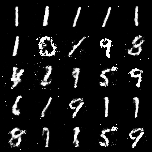

In [24]:
from IPython.display import Image

Image('92000.png')

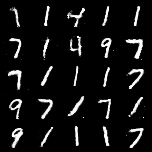

In [26]:
Image('234000.png')

### 이미지 gif로 변환

In [16]:
import imageio
import os

In [22]:
directory = r'./mnist_Image'      # 사진 디렉토리
file_type = r'png'               # 사진 확장자
save_gif_name = r'Animation'     # 완성 gif 이름
speed_sec = { 'duration': 0.3 }   # 사진 넘기는 시간(초)

In [23]:
images = []
for file_name in os.listdir(directory):
    if file_name.endswith('.{}'.format(file_type)):
        file_path = os.path.join(directory, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('{}/{}.gif'.format(directory, save_gif_name), images, **speed_sec)